## Import 및 함수정의

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text, export_graphviz
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm
from catboost import Pool, CatBoostClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.plotting import plot_decision_regions

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn import metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, precision_score, recall_score, f1_score)

from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
import shap 

from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

In [2]:
# 함수 정의
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]

    
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test
    #X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)


    #scaler = preprocessing.MinMaxScaler()
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                              index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
    #X_train_scaled, X_test_scaled = scale(scaler, X_train, X_test)
    #print(X_train_scaled.shape, Y_train.shape)
    #print(X_test_scaled.shape, Y_test.shape)

def preprocessing_Education(df) :
  
    # 비형식학습 참여 집단
    Y_colname = ['비형식교육 참여여부']
    
    # 데이터 분리
    X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

    # Undersampling
    sampling_method = 'RandomUnderSampler'
    sampling_strategy = 'auto'    # 'minority', 'not majority', 'not minority', 'all', 'auto'
    random_state=123

    sampler, X_train, Y_train = undersampling(X_train, Y_train, 
                                              method=sampling_method, strategy=sampling_strategy, 
                                              random_state=random_state)  
    X_test, Y_test = sampler.fit_resample(X_test, Y_test) 

    #스케일 조정
    scaler = preprocessing.MinMaxScaler()
    X_train_scaled, X_test_scaled = scale(scaler, X_train, X_test)
    print(X_train_scaled.shape, Y_train.shape)
    print(X_test_scaled.shape, Y_test.shape)
    
    return X_train_scaled, X_test_scaled, Y_train, Y_test

def undersampling(X_train, Y_train, method='OneSidedSelection', strategy='auto', random_state=123):
    print('Ratio of Origin Y: ', Y_train.value_counts())
    if method == 'RandomUnderSampler':
        sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=random_state)
    elif method == 'TomekLinks':
        sampler = TomekLinks(sampling_strategy=strategy)
    elif method == 'CondensedNearestNeighbour':
        sampler = CondensedNearestNeighbour(sampling_strategy=strategy, random_state=random_state)
    elif method == 'OneSidedSelection':
        sampler = OneSidedSelection(sampling_strategy=strategy, random_state=random_state)
        
    # 축소
    X_train, Y_train = sampler.fit_resample(X_train, Y_train)
    print('Ratio of Sapling Y: ', Y_train.value_counts())
    
    return sampler, X_train, Y_train


# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true>=0.5, Y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['True: 0', 'True: 1'], 
                            columns=['Pred: 0', 'Pred: 1'])
    
    return conf_mat


# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5)):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


# Precision & Recall Curve 함수화
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


def evaluation_class_AccuracyAUC(Y_real, Y_pred_prob):
    # 0.5 기준으로 확률을 이진 레이블로 변환하여 accuracy 계산
    Y_pred_label = np.where(Y_pred_prob >= 0.5, 1, 0)
    accuracy = accuracy_score(Y_real, Y_pred_label)
    roc_auc = roc_auc_score(Y_real, Y_pred_prob)  # 확률 값을 그대로 사용
    result = pd.DataFrame({'Accuracy': [accuracy], 'ROC_AUC': [roc_auc]})

    # 소수점 5자리까지 표시
    result = result.applymap(lambda x: '{:.5f}'.format(x))
    return result

def evaluation_class_AccuracyAUC_trte(Y_real_tr, Y_pred_tr_prob, Y_real_te, Y_pred_te_prob):
    Score_tr = evaluation_class_AccuracyAUC(Y_real_tr, Y_pred_tr_prob)
    Score_te = evaluation_class_AccuracyAUC(Y_real_te, Y_pred_te_prob)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    # 소수점 5자리까지 표시
    Score_trte = Score_trte.applymap(lambda x: '{:.5f}'.format(float(x)))
    return Score_trte


## 1. x 30개 컬럼 / 언더샘플링, 샘플러 O
- 파생변수 처리는 preprocessing 파일 참고
- 선택한 컬럼과 파생변수 설명은 액셀파일 참고해주세요!

In [3]:
#250416 컬럼선택
selcted_cols = ['평생학습 효과성 평균', '학습 지향 평균', '직업관련 목표지향 평균', '무형식학습(의존형) 참여', 
                    '무형식학습(온라인) 참여', '무형식학습 (암묵적 학습) 참여', '사회참여', 
                    '문D1) 귀하께서는 작년에 평생교육 프로그램 관련 정보를 접한 적이 있습니까?', '문H1) 귀하께서는 전반적으로 현재의 생활에 얼마나 만족하십니까?',
                    '문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1', '문C2) 귀하께서는 작년(교육이나 학습 프로그램의 참여여부와 관계없이)에 참여하고 싶었지만 참여하지 못했던 평생교육 프로그램이 있었습니까?', 
                    '문E1-1) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 책이나 판서 수업 중심으로 공부하는 것이 익숙하고 잘된다.',
                    '문E1-2) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 인터넷강의 또는 컴퓨터(전자책^ 태블릿 PC^스마트폰)를 활용한 학습이 익숙하고 잘된다.',
                    '문E1-3) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 혼자서 공부하는 것이 익숙하고 좋다.',
                    '문E1-4) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 다른 사람들과 함께 공부 하는 것이 좋다.',
                    '성별', '연령별(1)', '학력별', '경활상태', '월 가구소득', '지역규모별', '부양가족 유무', '건강에 대한 자신감', '취업구분',
                    '근로시간형태', '직업', '직장의 규모', '근무기간', '형식교육 참여자', 'key', '비형식교육 참여여부'        
    ]
file_path = r"C:/Users/JONJI/EducationCompetition/df_preprocessing_0415.csv"
# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv(file_path)
df = df[selcted_cols]

SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Education(df)
#X_train, X_test, Y_train, Y_test = preprocessing_Education(df)

(41095, 30) (41095, 1)
(10274, 30) (10274, 1)
Ratio of Origin Y:  비형식교육 참여여부
0             26589
1             14506
Name: count, dtype: int64
Ratio of Sapling Y:  비형식교육 참여여부
0             14506
1             14506
Name: count, dtype: int64
(29012, 30) (29012, 1)
(7222, 30) (7222, 1)


In [4]:
## 전반적인 모델링 성능 확인

# 모델 정의 
models = {
    'Logistic Regression' : LogisticRegression(fit_intercept=False),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123),
    'XGBoost': XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3, random_state=123),
    'CatBoost': CatBoostClassifier(n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3, random_state=123,
                              verbose=0),
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(X_train_scaled, Y_train)
    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)

    # 평가 지표
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)


    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df_del = pd.DataFrame(results)
# 소수점 6자리까지 표시
results_df_del1 = results_df_del.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, (int, float)) else x)

------Logistic Regression------
------Random Forest------
------XGBoost------
------LightGBM------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14506, number of negative: 14506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 29012, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [5]:
results_df_del1 
#rf 성능이 제일 좋지만, shap 오류가 있어 LightGBM으로 분석 진행

,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.688016,0.669344,0.696483,0.678551,0.682913,0.745197
1,Random Forest,0.701335,0.698421,0.702575,0.699875,0.700498,0.776800
2,XGBoost,0.688485,0.702022,0.682359,0.695187,0.692191,0.767075
3,LightGBM,0.690294,0.701191,0.685406,0.695700,0.693298,0.767776
4,CatBoost,0.687889,0.703129,0.680975,0.695426,0.692052,0.759697


(41095, 30) (41095, 1)
(10274, 30) (10274, 1)
Ratio of Origin Y:  비형식교육 참여여부
0             26589
1             14506
Name: count, dtype: int64
Ratio of Sapling Y:  비형식교육 참여여부
0             14506
1             14506
Name: count, dtype: int64
(29012, 30) (29012, 1)
(7222, 30) (7222, 1)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14506, number of negative: 14506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 29012, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Importance
평생학습_효과성_평균,42
학습_지향_평균,35
직업관련_목표지향_평균,21
무형식학습(의존형)_참여,7
무형식학습(온라인)_참여,7
...,...
직업,56
직장의_규모,52
근무기간,13
형식교육_참여자,6


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.70      0.68      0.69     14506
     class 1       0.69      0.71      0.70     14506

    accuracy                           0.70     29012
   macro avg       0.70      0.70      0.70     29012
weighted avg       0.70      0.70      0.70     29012

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.70      0.69      0.69      3611
     class 1       0.69      0.70      0.70      3611

    accuracy                           0.69      7222
   macro avg       0.69      0.69      0.69      7222
weighted avg       0.69      0.69      0.69      7222

ROC Curve: Train


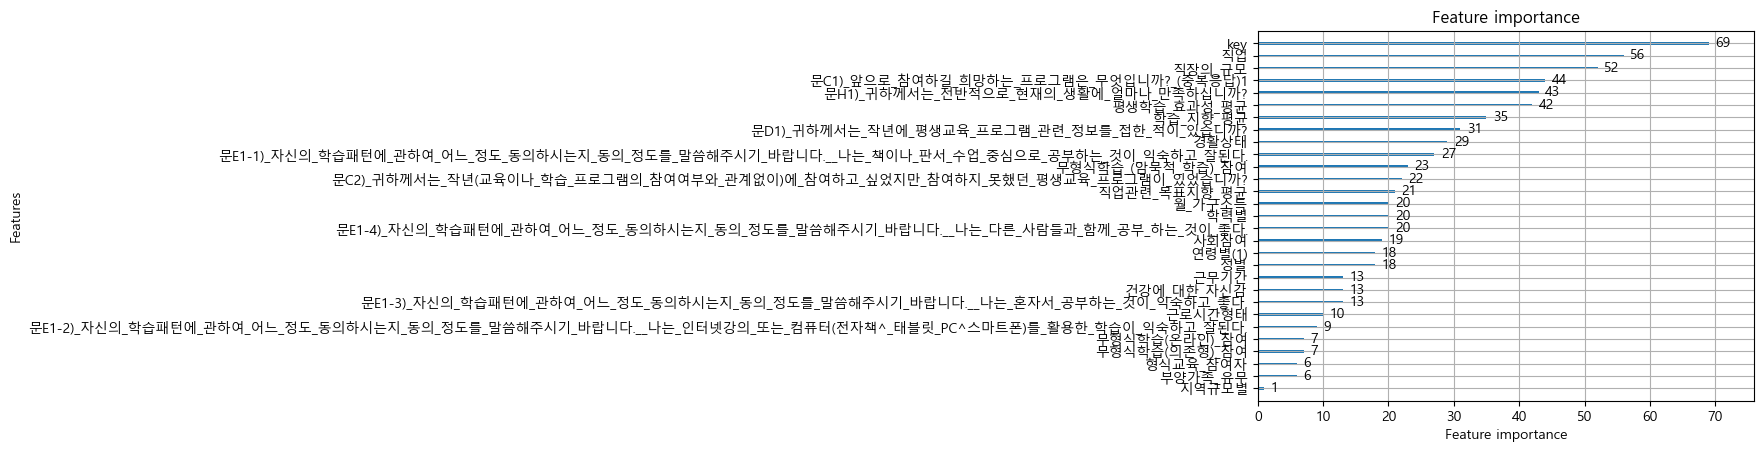

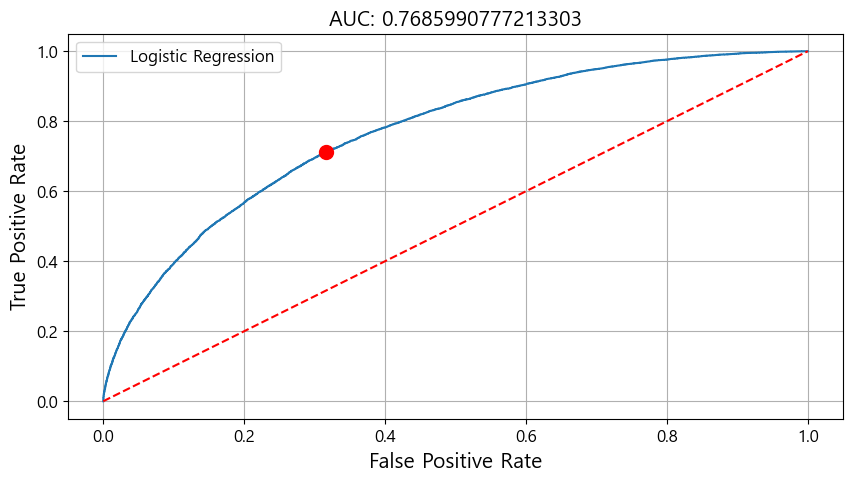

ROC Curve: Test


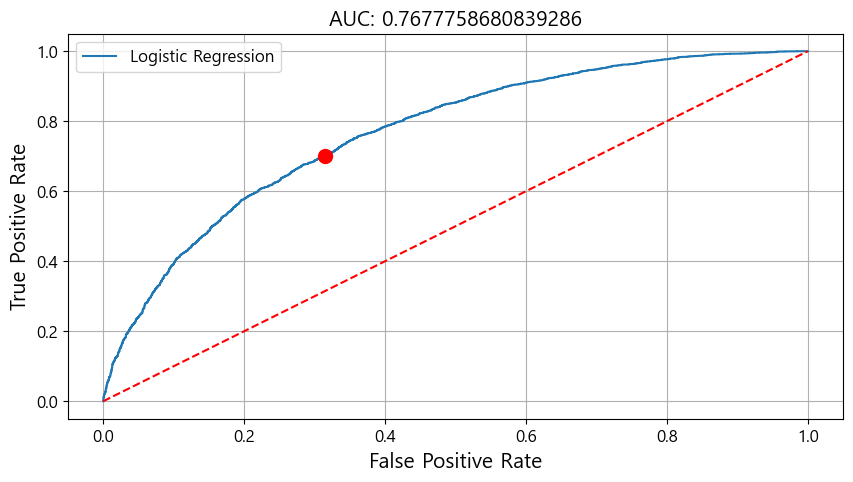

Precision-Recall Curve: Train


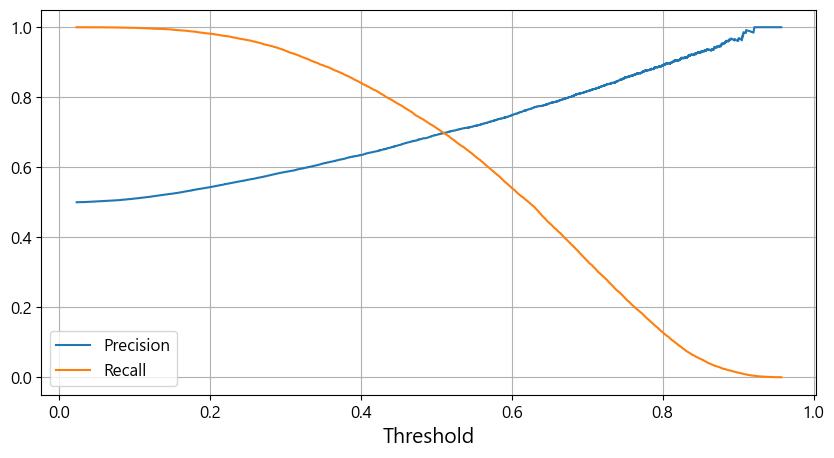

Precision-Recall Curve: Test


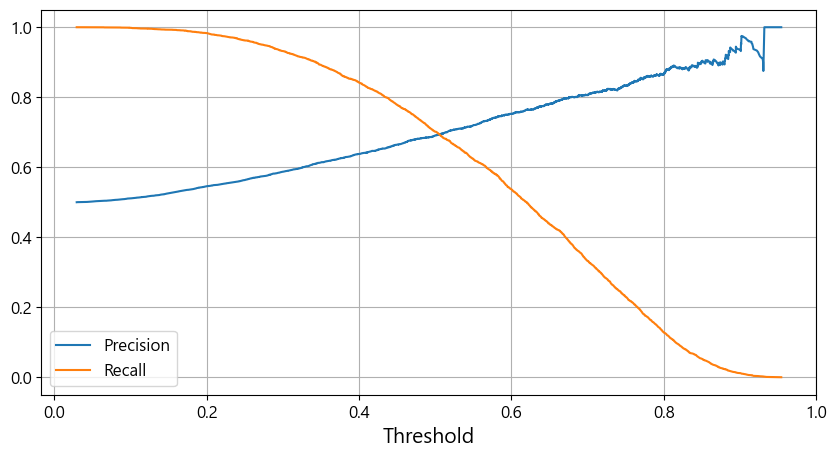

In [6]:
## lgbm 모델 성능 확인

#250416 컬럼선택
selcted_cols = ['평생학습 효과성 평균', '학습 지향 평균', '직업관련 목표지향 평균', '무형식학습(의존형) 참여', 
                '무형식학습(온라인) 참여', '무형식학습 (암묵적 학습) 참여', '사회참여', 
                '문D1) 귀하께서는 작년에 평생교육 프로그램 관련 정보를 접한 적이 있습니까?', '문H1) 귀하께서는 전반적으로 현재의 생활에 얼마나 만족하십니까?',
                '문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1', '문C2) 귀하께서는 작년(교육이나 학습 프로그램의 참여여부와 관계없이)에 참여하고 싶었지만 참여하지 못했던 평생교육 프로그램이 있었습니까?', 
                '문E1-1) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 책이나 판서 수업 중심으로 공부하는 것이 익숙하고 잘된다.',
                '문E1-2) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 인터넷강의 또는 컴퓨터(전자책^ 태블릿 PC^스마트폰)를 활용한 학습이 익숙하고 잘된다.',
                '문E1-3) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 혼자서 공부하는 것이 익숙하고 좋다.',
                '문E1-4) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 다른 사람들과 함께 공부 하는 것이 좋다.',
                '성별', '연령별(1)', '학력별', '경활상태', '월 가구소득', '지역규모별', '부양가족 유무', '건강에 대한 자신감', '취업구분',
                '근로시간형태', '직업', '직장의 규모', '근무기간', '형식교육 참여자', 'key', '비형식교육 참여여부'        
    ]
file_path = r"C:/Users/JONJI/EducationCompetition/df_preprocessing_0415.csv"

# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv(file_path)
df = df[selcted_cols]

SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Education(df)


# LightGBM
model_lgbm = LGBMClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3, random_state=123)
model_lgbm.fit(X_train_scaled, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_lgbm.feature_importances_, 
                     index=model_lgbm.feature_name_, columns=['Importance']))
print("변수 중요도(성능기준): ")
plot_importance_lgbm(model_lgbm)

# 예측
Y_trpred = model_lgbm.predict(X_train_scaled)
Y_tepred = model_lgbm.predict(X_test_scaled)
P_trpred = model_lgbm.predict_proba(X_train_scaled)
P_tepred = model_lgbm.predict_proba(X_test_scaled)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

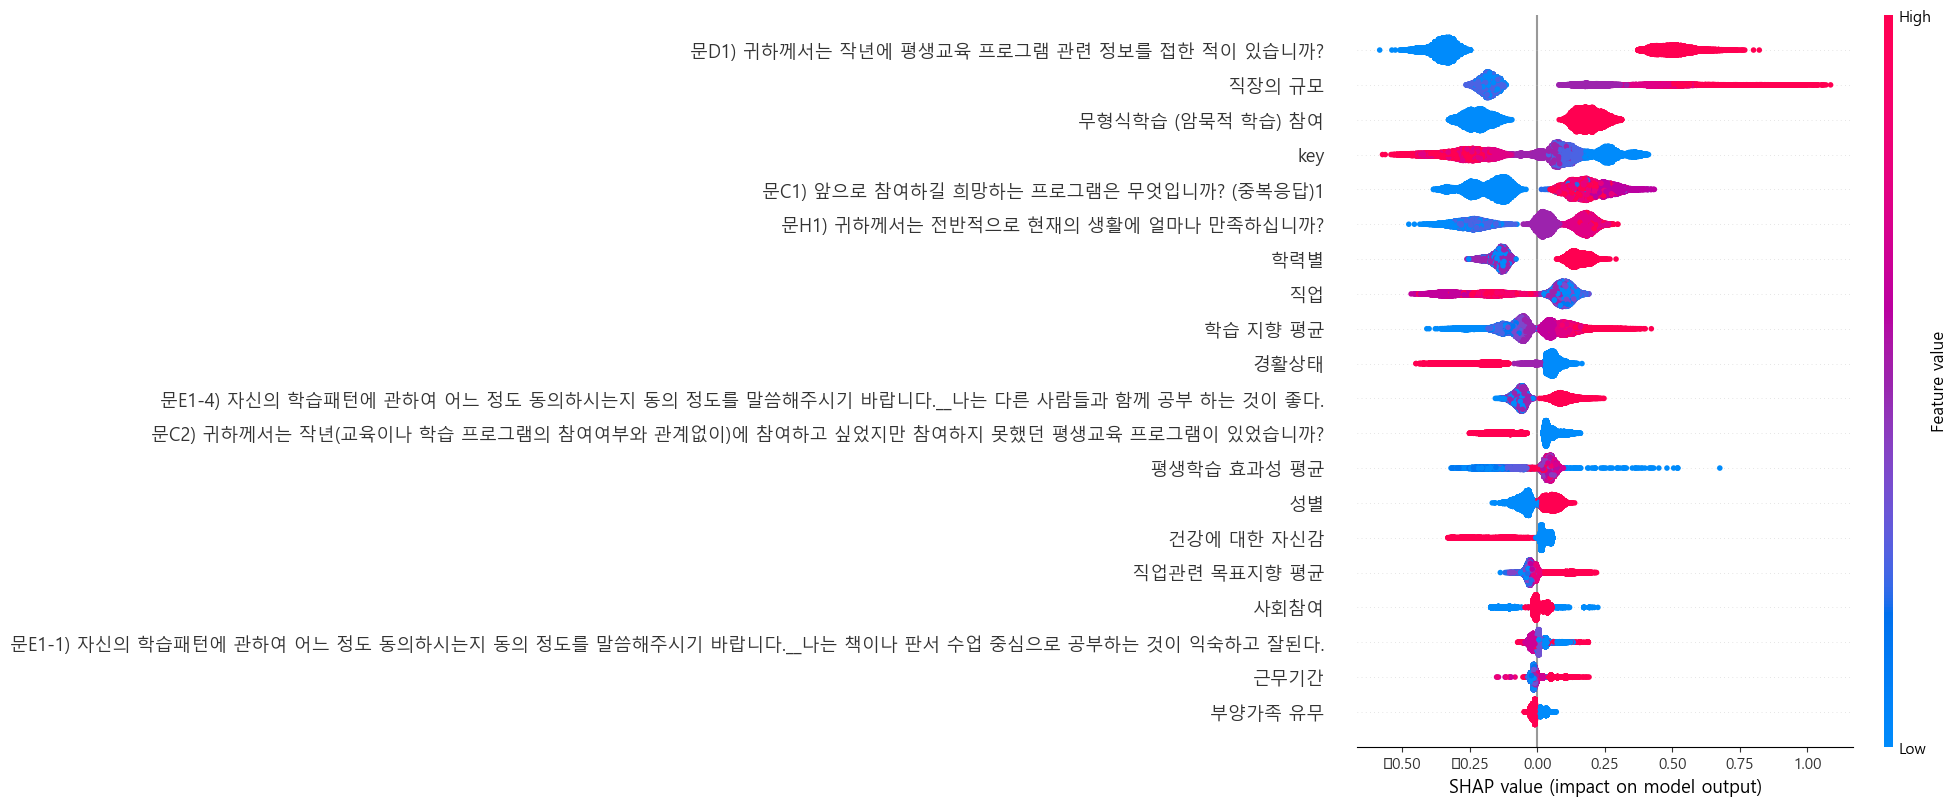

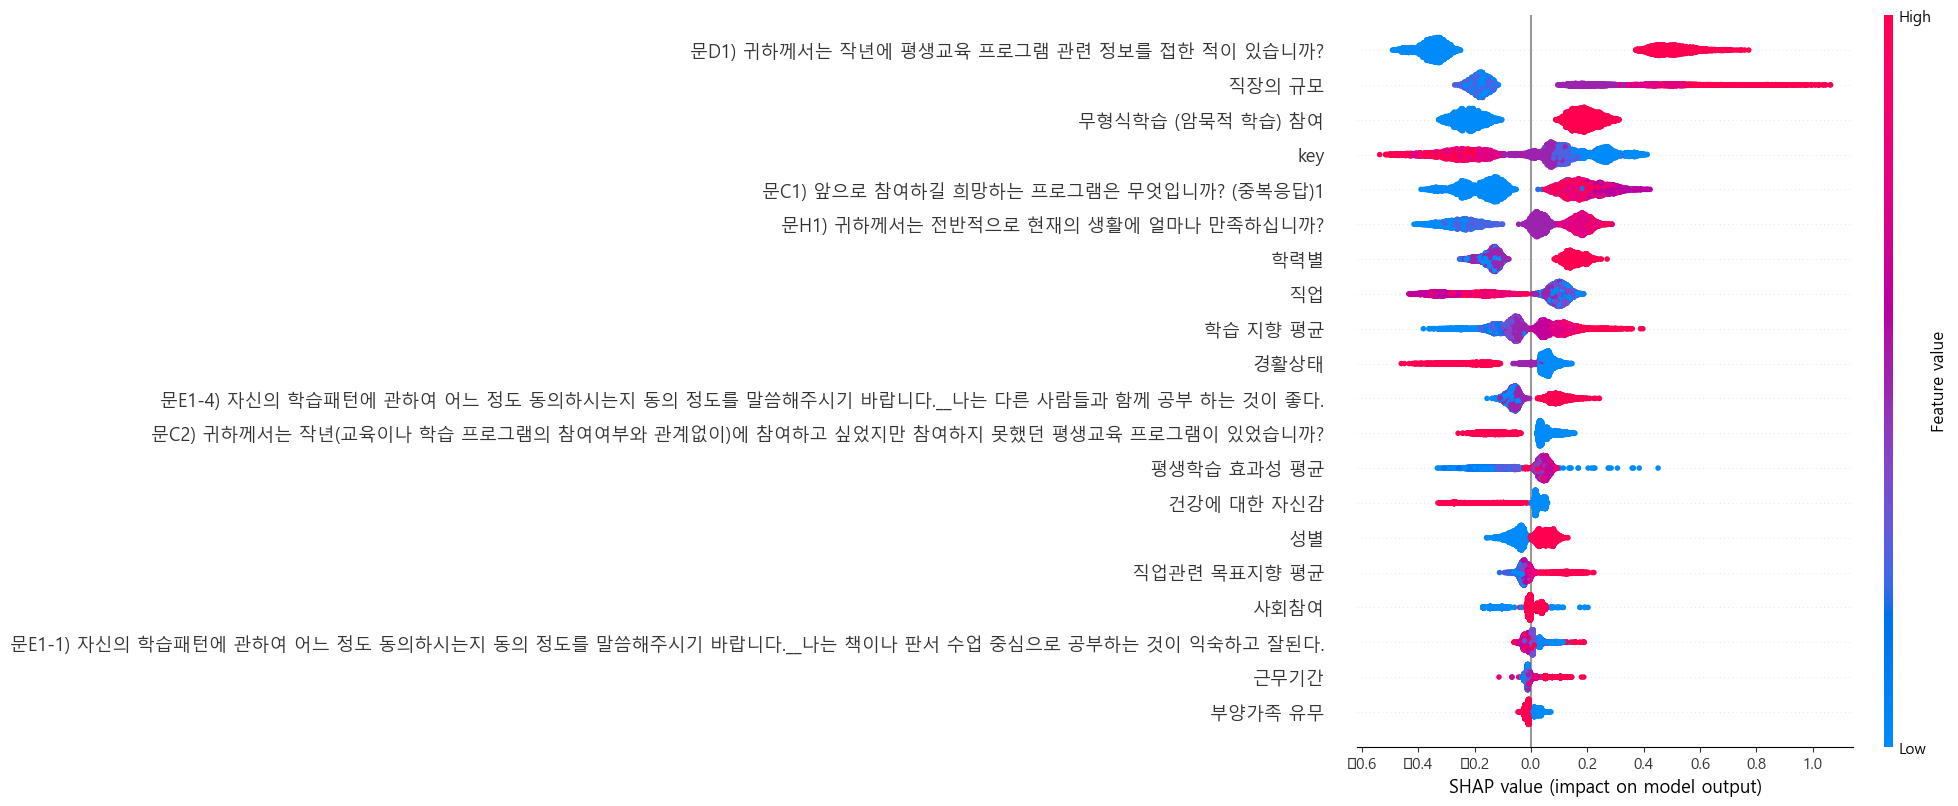

In [7]:
## SHAP 분석 
shap.initjs()

# 설명 모델 생성
explainer = shap.TreeExplainer(model_lgbm)
# 트레인 셋에서의 SHAP value
shap_values_train = explainer.shap_values(X_train_scaled)
# 테스트 셋에서의 SHAP value
shap_values_test = explainer.shap_values(X_test_scaled)

#트레이닝 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_train,X_train_scaled) 
 
#테스트 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_test,X_test_scaled)

## 2. 컬럼 재선택 후 모델링 (x컬럼 36개)
- shap 분석 중 '평생학습 효과성 평균', '사회참여' 컬럼의 모호성이 있다고 판단
- 두 파생변수를 개별변수로 바꾸어 컬럼 선택

In [8]:
#250416 컬럼선택
selcted_cols = ['학습 지향 평균', '직업관련 목표지향 평균', '무형식학습(의존형) 참여', 
                #'평생학습 효과성 평균', 
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__1) 정신적 건강(정서적 안정감)',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__2) 육체적 건강',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__3) 사회참여 만족도',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__4) 경제적 안정감',
                '무형식학습(온라인) 참여', '무형식학습 (암묵적 학습) 참여', 
                #'사회참여', 
                '문G1-1) 지난 한 해 동안 자원봉사 또는 재능기부를 한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-2) 지난 한 해 동안 자선단체에 기부 또는 후원한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-3) 지난 한 해 동안 동아리에서 활동한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-4) 지난 한 해 동안 지역사회단체에 참여한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문D1) 귀하께서는 작년에 평생교육 프로그램 관련 정보를 접한 적이 있습니까?', '문H1) 귀하께서는 전반적으로 현재의 생활에 얼마나 만족하십니까?',
                '문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1', '문C2) 귀하께서는 작년(교육이나 학습 프로그램의 참여여부와 관계없이)에 참여하고 싶었지만 참여하지 못했던 평생교육 프로그램이 있었습니까?', 
                '문E1-1) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 책이나 판서 수업 중심으로 공부하는 것이 익숙하고 잘된다.',
                '문E1-2) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 인터넷강의 또는 컴퓨터(전자책^ 태블릿 PC^스마트폰)를 활용한 학습이 익숙하고 잘된다.',
                '문E1-3) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 혼자서 공부하는 것이 익숙하고 좋다.',
                '문E1-4) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 다른 사람들과 함께 공부 하는 것이 좋다.',
                '성별', '연령별(1)', '학력별', '경활상태', '월 가구소득', '지역규모별', '부양가족 유무', '건강에 대한 자신감', '취업구분',
                '근로시간형태', '직업', '직장의 규모', '근무기간', '형식교육 참여자', 'key', '비형식교육 참여여부'
    ]
file_path = r"C:/Users/JONJI/EducationCompetition/df_preprocessing_0415.csv"

# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv(file_path)
df = df[selcted_cols]

SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Education(df)

(41095, 36) (41095, 1)
(10274, 36) (10274, 1)
Ratio of Origin Y:  비형식교육 참여여부
0             26589
1             14506
Name: count, dtype: int64
Ratio of Sapling Y:  비형식교육 참여여부
0             14506
1             14506
Name: count, dtype: int64
(29012, 36) (29012, 1)
(7222, 36) (7222, 1)


In [9]:
# 모델 정의 
models = {
    'Logistic Regression' : LogisticRegression(fit_intercept=False),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123),
    'XGBoost': XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3, random_state=123),
    'CatBoost': CatBoostClassifier(n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3, random_state=123,
                              verbose=0),
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(X_train_scaled, Y_train)
    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)

    # 평가 지표
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)


    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df_del = pd.DataFrame(results)
# 소수점 6자리까지 표시
results_df_del2 = results_df_del.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, (int, float)) else x)

------Logistic Regression------
------Random Forest------
------XGBoost------
------LightGBM------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14506, number of negative: 14506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 29012, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [10]:
results_df_del2 #XGB 선택

,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.686791,0.671005,0.693991,0.678807,0.682498,0.746442
1,Random Forest,0.709713,0.712268,0.708668,0.710988,0.710468,0.784130
2,XGBoost,0.693916,0.707560,0.687898,0.700672,0.697729,0.770452
3,LightGBM,0.693794,0.705899,0.688452,0.699794,0.697175,0.770339
4,CatBoost,0.690775,0.700914,0.686236,0.695808,0.693575,0.766033


(41095, 36) (41095, 1)
(10274, 36) (10274, 1)
Ratio of Origin Y:  비형식교육 참여여부
0             26589
1             14506
Name: count, dtype: int64
Ratio of Sapling Y:  비형식교육 참여여부
0             14506
1             14506
Name: count, dtype: int64
(29012, 36) (29012, 1)
(7222, 36) (7222, 1)
변수 중요도(분류기준): 


,Importance
학습 지향 평균,0.03
직업관련 목표지향 평균,0.01
무형식학습(의존형) 참여,0.01
문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__1) 정신적 건강(정서적 안정감),0.03
문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__2) 육체적 건강,0.00
...,...
직업,0.02
직장의 규모,0.07
근무기간,0.01
형식교육 참여자,0.01


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.71      0.68      0.69     14506
     class 1       0.69      0.71      0.70     14506

    accuracy                           0.70     29012
   macro avg       0.70      0.70      0.70     29012
weighted avg       0.70      0.70      0.70     29012

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.70      0.69      0.69      3611
     class 1       0.69      0.71      0.70      3611

    accuracy                           0.70      7222
   macro avg       0.70      0.70      0.70      7222
weighted avg       0.70      0.70      0.70      7222

ROC Curve: Train


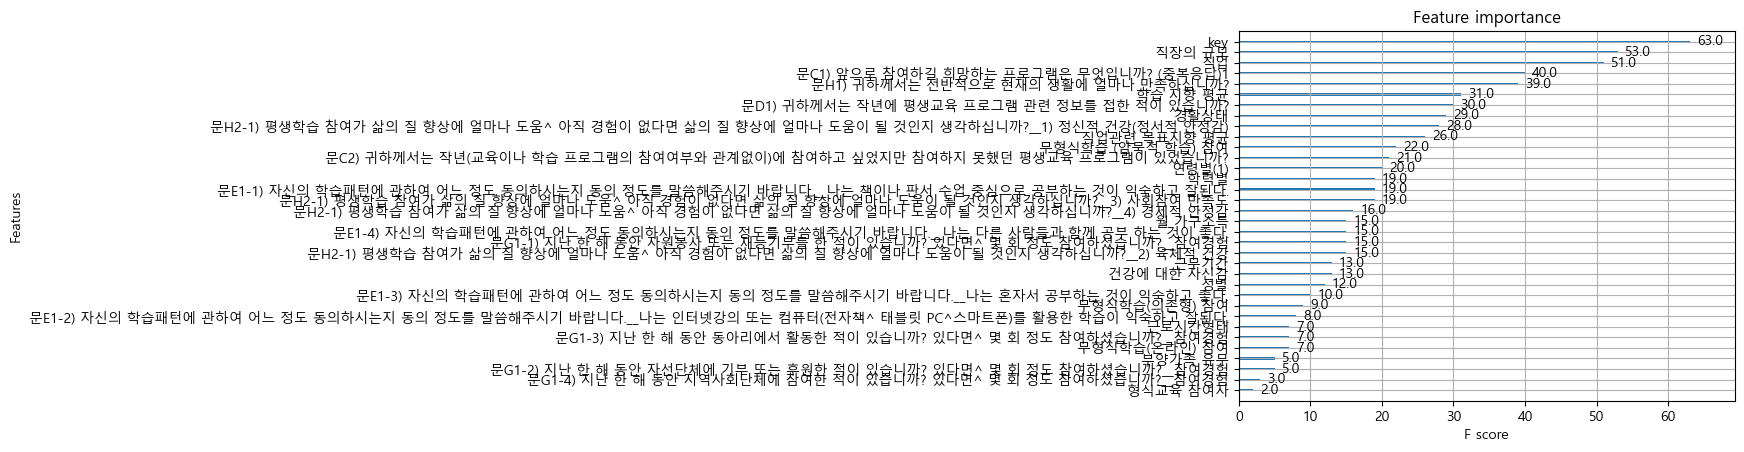

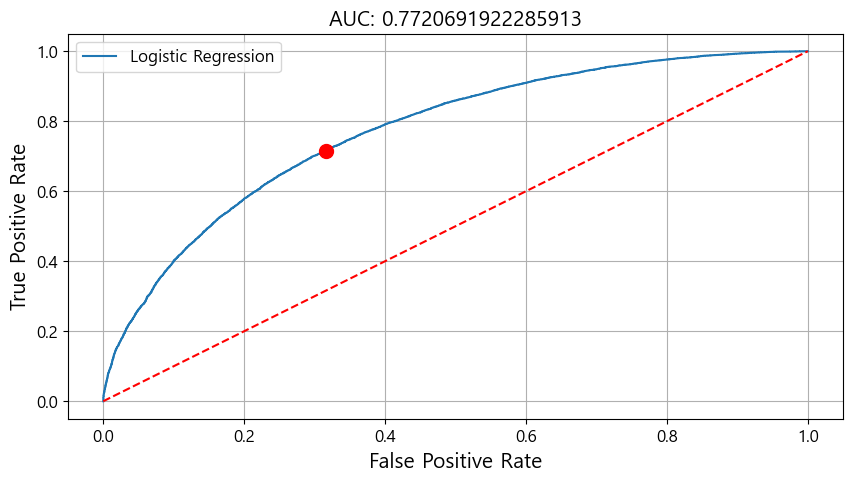

ROC Curve: Test


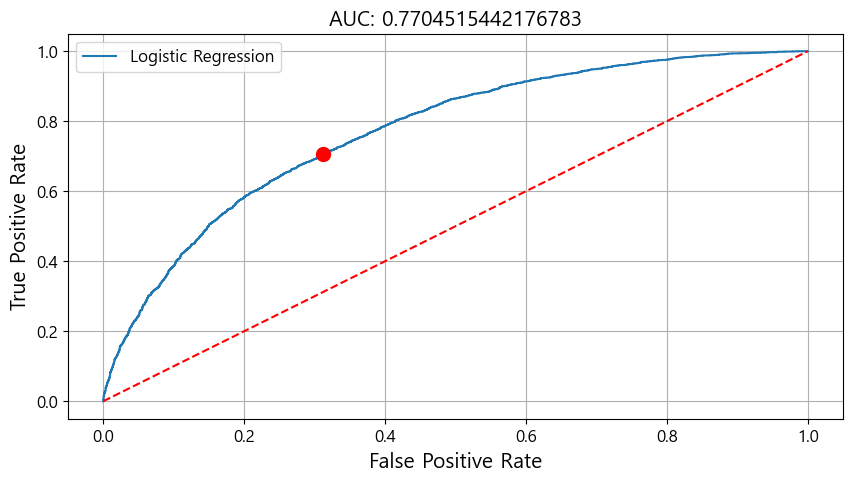

Precision-Recall Curve: Train


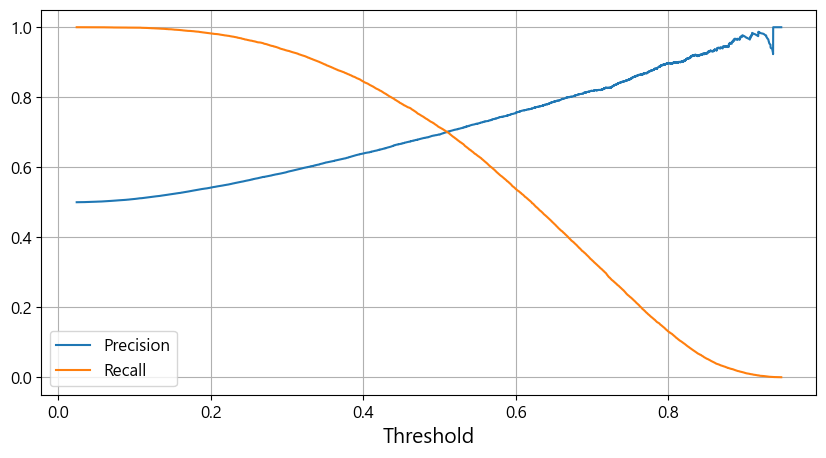

Precision-Recall Curve: Test


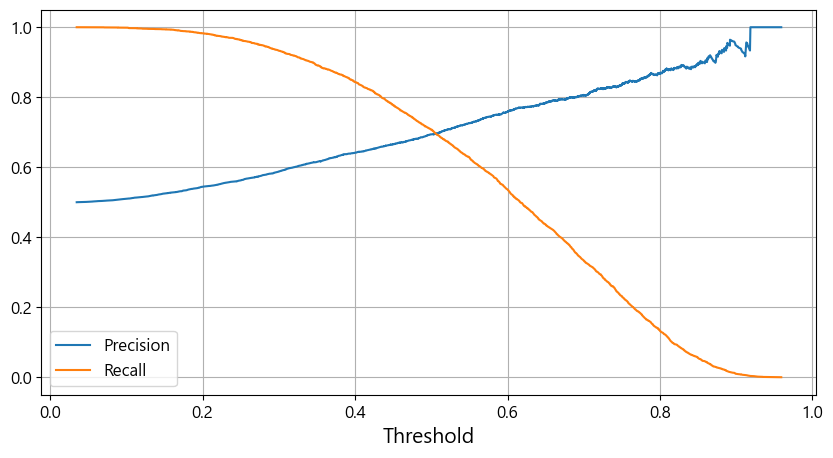

In [11]:
#250421 컬럼선택
selcted_cols = ['학습 지향 평균', '직업관련 목표지향 평균', '무형식학습(의존형) 참여', #'평생학습 효과성 평균', 
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__1) 정신적 건강(정서적 안정감)',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__2) 육체적 건강',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__3) 사회참여 만족도',
                '문H2-1) 평생학습 참여가 삶의 질 향상에 얼마나 도움^ 아직 경험이 없다면 삶의 질 향상에 얼마나 도움이 될 것인지 생각하십니까?__4) 경제적 안정감',
                '무형식학습(온라인) 참여', '무형식학습 (암묵적 학습) 참여', #'사회참여', 
                '문G1-1) 지난 한 해 동안 자원봉사 또는 재능기부를 한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-2) 지난 한 해 동안 자선단체에 기부 또는 후원한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-3) 지난 한 해 동안 동아리에서 활동한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문G1-4) 지난 한 해 동안 지역사회단체에 참여한 적이 있습니까? 있다면^ 몇 회 정도 참여하셨습니까?__참여경험',
                '문D1) 귀하께서는 작년에 평생교육 프로그램 관련 정보를 접한 적이 있습니까?', '문H1) 귀하께서는 전반적으로 현재의 생활에 얼마나 만족하십니까?',
                '문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1', '문C2) 귀하께서는 작년(교육이나 학습 프로그램의 참여여부와 관계없이)에 참여하고 싶었지만 참여하지 못했던 평생교육 프로그램이 있었습니까?', 
                '문E1-1) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 책이나 판서 수업 중심으로 공부하는 것이 익숙하고 잘된다.',
                '문E1-2) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 인터넷강의 또는 컴퓨터(전자책^ 태블릿 PC^스마트폰)를 활용한 학습이 익숙하고 잘된다.',
                '문E1-3) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 혼자서 공부하는 것이 익숙하고 좋다.',
                '문E1-4) 자신의 학습패턴에 관하여 어느 정도 동의하시는지 동의 정도를 말씀해주시기 바랍니다.__나는 다른 사람들과 함께 공부 하는 것이 좋다.',
                '성별', '연령별(1)', '학력별', '경활상태', '월 가구소득', '지역규모별', '부양가족 유무', '건강에 대한 자신감', '취업구분',
                '근로시간형태', '직업', '직장의 규모', '근무기간', '형식교육 참여자', 'key', '비형식교육 참여여부'
    ]
file_path = r"C:/Users/JONJI/EducationCompetition/df_preprocessing_0415.csv"

# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv(file_path)
df = df[selcted_cols]

SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Education(df)


# XGBoost
model_xgb = XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss')
model_xgb.fit(X_train_scaled, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_xgb.feature_importances_, 
                     index=model_xgb.feature_names_in_, columns=['Importance']))
print("변수 중요도(성능기준): ")
plot_importance_xgb(model_xgb)

# 예측
Y_trpred = model_xgb.predict(X_train_scaled)
Y_tepred = model_xgb.predict(X_test_scaled)
P_trpred = model_xgb.predict_proba(X_train_scaled)
P_tepred = model_xgb.predict_proba(X_test_scaled)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

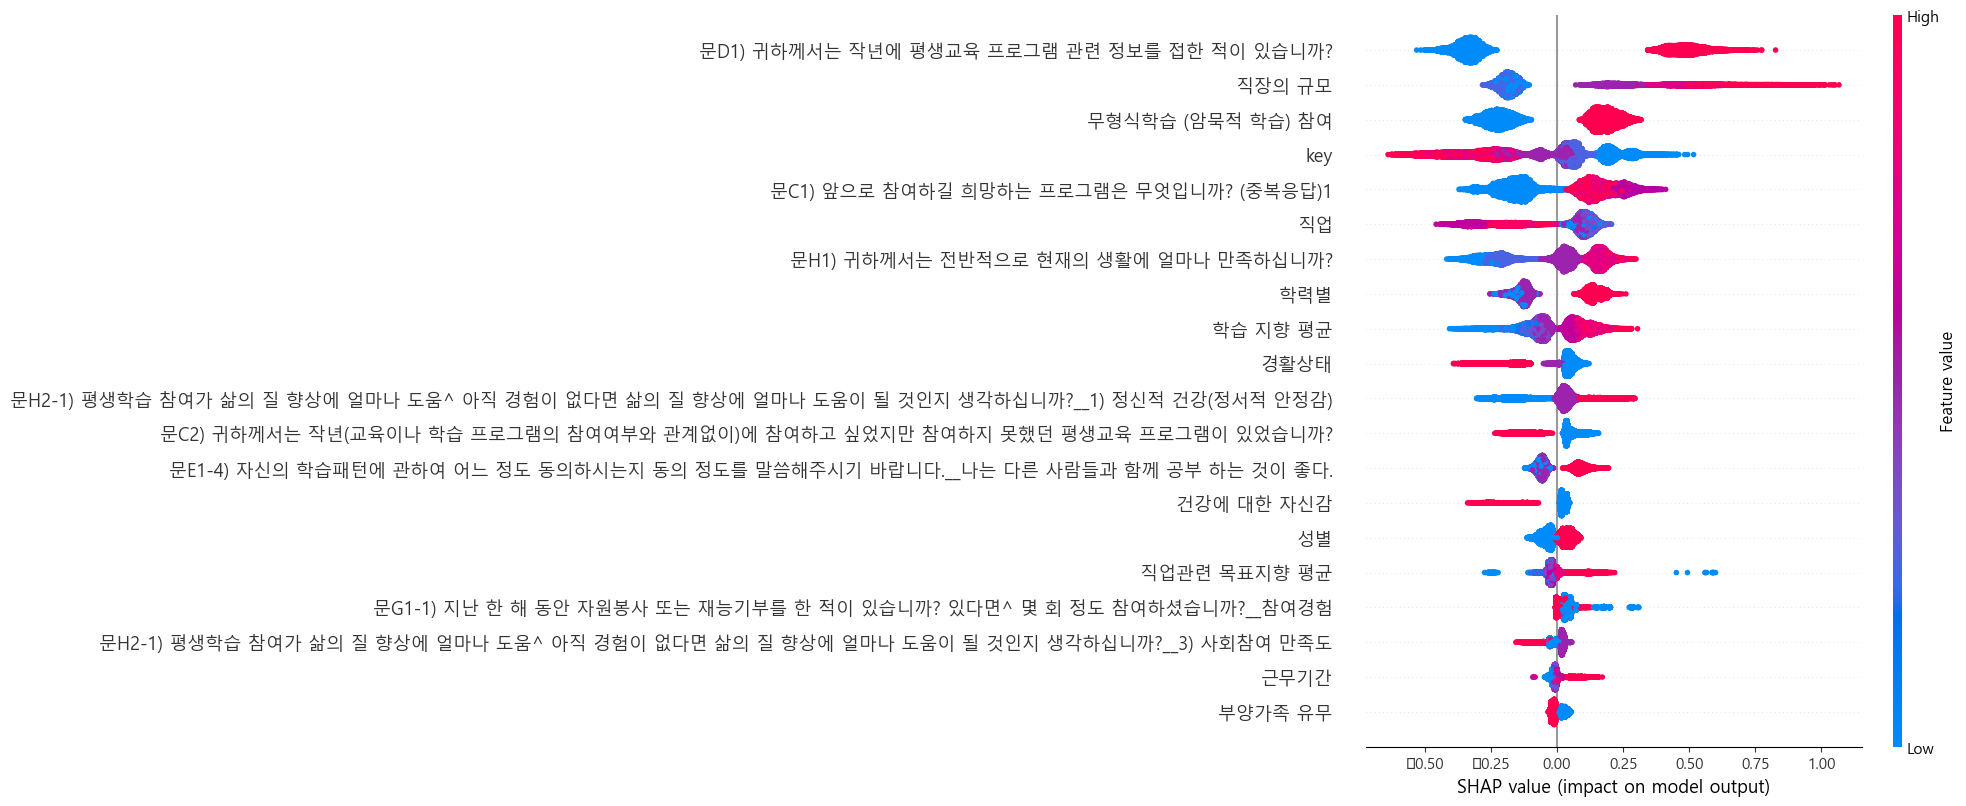

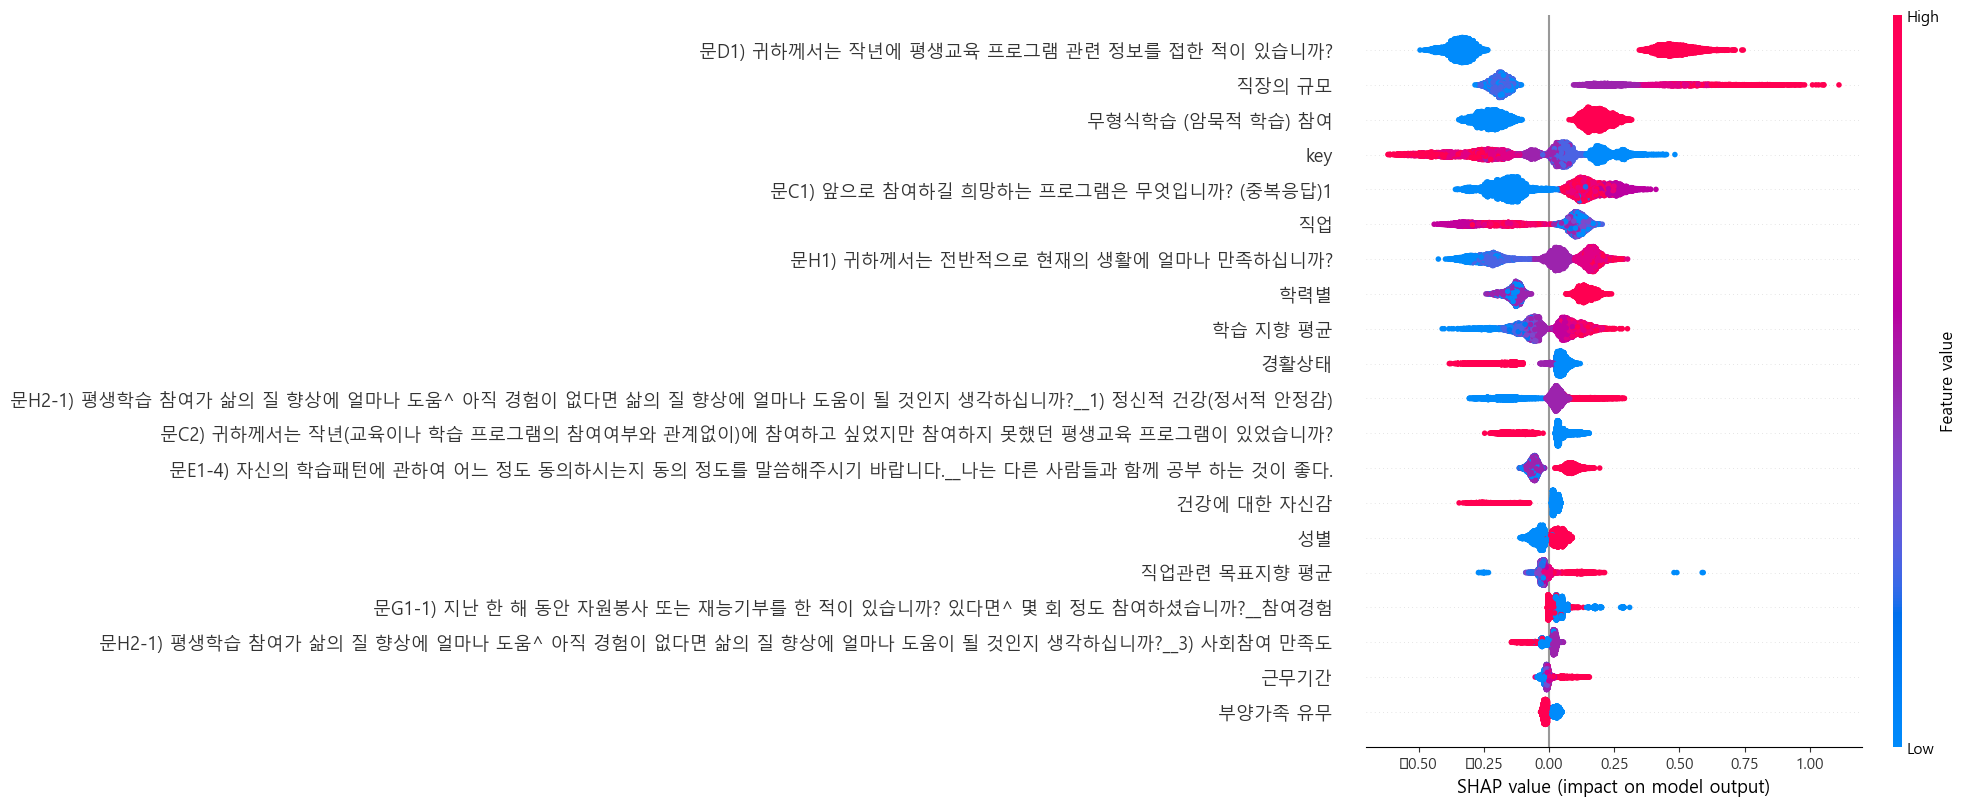

In [12]:
shap.initjs()

# 설명 모델 생성
explainer = shap.TreeExplainer(model_xgb)
# 트레인 셋에서의 SHAP value
shap_values_train = explainer.shap_values(X_train_scaled)
# 테스트 셋에서의 SHAP value
shap_values_test = explainer.shap_values(X_test_scaled)

#트레이닝 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_train,X_train_scaled) 
 
#테스트 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_test,X_test_scaled)